# MNIST: convolutional neural networks

We define and train a convolutional neural network (CNN) model to recognize handwritten digits.  Although CNNs can be used in many contexts, they are probably most often used in the context of image processing.

## Required imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

2025-01-14 13:59:52.237913: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-14 13:59:52.248490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-14 13:59:52.260341: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-14 13:59:52.263459: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 13:59:52.274472: I tensorflow/core/platform/cpu_feature_guar

## Data preparation

Depending on the backend keras uses, the input format slightly differs. Either the number of color channels is the first, or the last dimension.  Our input data is grayscale, so there is only a single color channel

In [2]:
img_channels, img_rows, img_cols = 1, 28, 28

if K.image_data_format() == 'channels_first':
    shape_ord = (img_channels, img_rows, img_cols)
else:  # channel_last
    shape_ord = (img_rows, img_cols, img_channels)

Load the data again.

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In order to make this reproducible, we have to seed the random number generator.

In [4]:
np.random.seed(1234)

During the training, we will require a validation set, so we split the training data into two sets, one for actual training, the other for validation.  Note, we don't touch the test data set at all during the training process.  The default is using 75 % of the data for training, 25 % for validation. This function will also shuffle the data set prior to splitting (hence seeding the random number generator).

In [5]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train)

### Data preprocessing

First, reshape the input data to take into account the color channels of the images.

In [6]:
input_pipeline = Pipeline([
    ('reshape',
     FunctionTransformer(
        lambda x: x.reshape((x.shape[0], ) + shape_ord).astype(np.float32)/255.0,
        validate=False
    )
    ),
    ('type cast',
     FunctionTransformer(
         lambda x: tf.convert_to_tensor(x),
         validate=False
     )
    ),
])

In [7]:
x_train = input_pipeline.fit_transform(x_train)
x_val = input_pipeline.transform(x_val)
x_test = input_pipeline.transform(x_test)

I0000 00:00:1736859596.016787    6986 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1736859596.151868    6986 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1736859596.152057    6986 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1736859596.156755    6986 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1736859596.157474    6986 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Most learning algorithms work better when the input data is normalized to the interval $[0, 1]$.

The output can be transformed using the pipeline defined for the multilayer network and can be imported from the `mnist_utils` module.

In [8]:
output_reshaper = FunctionTransformer(lambda x: x.reshape(-1, 1),
                                      validate=False)
output_encoder = OneHotEncoder(categories='auto')

The output values are stored in a `scipy` sparse matrix in CSR format.  TensorFlow can not handle this datatype directly, so it has to be converted to a TensorFlow sparse tensor.  The following function can do this.

In [9]:
def scipy_sparse_to_tf_sparse(X):
    X_coo = X.tocoo()
    indices = np.stack(X_coo.coords).transpose()
    return tf.SparseTensor(indices, X_coo.data, X_coo.shape)

In [10]:
output_type_changer = FunctionTransformer(
    lambda x: x.todense(),
    validate=False
)

In [11]:
output_pipeline = Pipeline([
    ('reshaper', output_reshaper),
    ('binarizer', output_encoder),
    ('type_changer', output_type_changer),
])

In [12]:
y_train = output_pipeline.fit_transform(y_train)
y_val = output_pipeline.transform(y_val)
y_test = output_pipeline.transform(y_test)

### Verification

Since we've done quite some transformations, let's verify whether we didn't mess up.

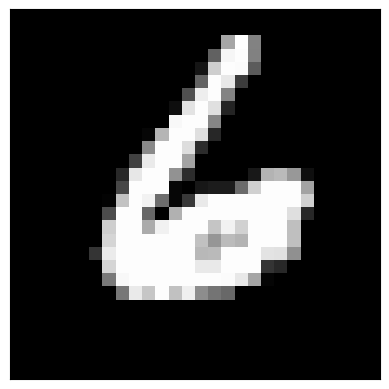

In [13]:
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.imshow(x_train[0, :, :, 0], cmap='gray');

In [14]:
y_train[0]

matrix([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

## Simple CNN

We start with a very straightforward network with a single convolutional layer.

### Required imports

In [15]:
from keras.models import Sequential
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten
from keras.optimizers import SGD
import tensorflow as tf

Seed TensorFlow's random number generator.

In [16]:
tf.random.set_seed(40580)

### Model definition

The network has 32 filters, each 3 $\times$ 3 pixels in its convolutional layer, and a ReLU activation function. For the second, dense layer, the output of the convolutional layer is first flattened. The dense layer's activation function is SoftMax to determine the category for the image.

In [17]:
nr_filters = 32
nr_classes = 10
conv_x_size, conv_y_size = 3, 3
cnn_model = Sequential()
cnn_model.add(Conv2D(nr_filters, (conv_x_size, conv_y_size), padding='valid',
                     input_shape=shape_ord))
cnn_model.add(Activation('relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(nr_classes))
cnn_model.add(Activation('softmax'))

/home/gjb/mambaforge/envs/machine_learning_with_python/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │       216,330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,650 (846.29 KB)

 Trainable params: 216,650 (846.29 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
cnn_hist = cnn_model.compile(loss='categorical_crossentropy',
                             optimizer=SGD(learning_rate=0.1, weight_decay=1.0e-6, 
                                           momentum=0.9, nesterov=True),
                             metrics=['accuracy'])

### Training

In [20]:
cnn_hist = cnn_model.fit(x_train, y_train, batch_size=32, epochs=10,
                         verbose=1, validation_data=(x_val, y_val))

Epoch 1/10


I0000 00:00:1736859597.764401    7048 service.cc:146] XLA service 0x7f7c88007d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736859597.764441    7048 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-01-14 13:59:57.776243: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-14 13:59:57.806965: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90300


  62/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6016 - loss: 1.2287  

I0000 00:00:1736859599.003341    7048 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8970 - loss: 0.3378 - val_accuracy: 0.9591 - val_loss: 0.1360
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9658 - loss: 0.1147 - val_accuracy: 0.9637 - val_loss: 0.1294
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9771 - loss: 0.0743 - val_accuracy: 0.9636 - val_loss: 0.1538
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9832 - loss: 0.0547 - val_accuracy: 0.9637 - val_loss: 0.1514
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9838 - loss: 0.0515 - val_accuracy: 0.9641 - val_loss: 0.1719
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9865 - loss: 0.0438 - val_accuracy: 0.9585 - val_loss: 0.1789
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9900 - loss: 0.0332 - val_accuracy: 0.9681 - val_loss: 0.1735
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9904 - loss: 0.0293 - val_accurac

In [21]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')

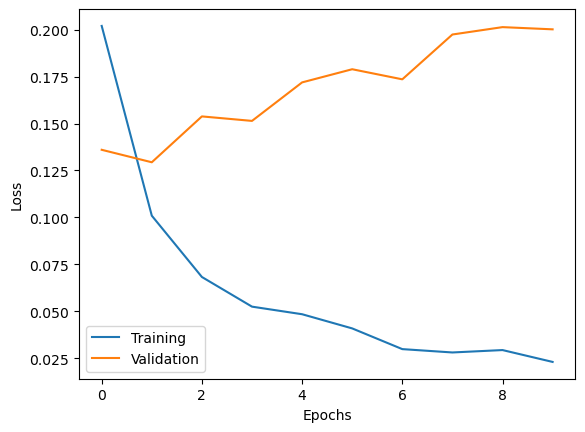

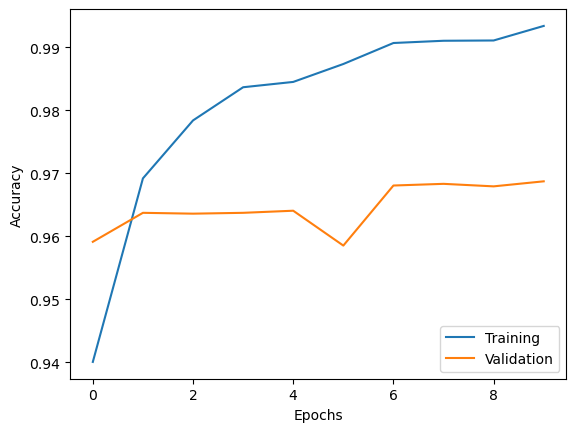

In [22]:
plot_history(cnn_hist)

In [23]:
cnn_model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9668 - loss: 0.2262     


[0.18003973364830017, 0.9732000231742859]

Although the test accuracy is quite acceptable, the training accuracy is a lot higher, so most likely there is some overfitting.

In [24]:
cnn_model.save('mnist_cnn.h5')

## More layers & dropout

This model has an additional hidden layer to improve accuracy.

In [25]:
nr_filters = 32
nr_classes = 10
conv_x_size, conv_y_size = 3, 3
cnn_do_model = Sequential()
cnn_do_model.add(Conv2D(nr_filters, (conv_x_size, conv_y_size), padding='valid',
                     input_shape=shape_ord))
cnn_do_model.add(Activation('relu'))
cnn_do_model.add(Flatten())
cnn_do_model.add(Dense(128))
cnn_do_model.add(Activation('relu'))
cnn_do_model.add(Dropout(0.1))
cnn_do_model.add(Dense(nr_classes))
cnn_do_model.add(Activation('softmax'))

In [26]:
cnn_do_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     2,769,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,770,634 (10.57 MB)

 Trainable params: 2,770,634 (10.57 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
cnn_do_model.compile(loss='categorical_crossentropy',
                     optimizer=SGD(),
                     metrics=['accuracy'])

In [28]:
cnn_do_hist = cnn_do_model.fit(x_train, y_train, batch_size=32, epochs=10,
                               verbose=1, validation_data=(x_val, y_val))

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8049 - loss: 0.7377 - val_accuracy: 0.9332 - val_loss: 0.2295
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9349 - loss: 0.2199 - val_accuracy: 0.9515 - val_loss: 0.1640
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9522 - loss: 0.1603 - val_accuracy: 0.9589 - val_loss: 0.1383
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9617 - loss: 0.1332 - val_accuracy: 0.9645 - val_loss: 0.1157
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9655 - loss: 0.1157 - val_accuracy: 0.9694 - val_loss: 0.1044
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9683 - loss: 0.1045 - val_accuracy: 0.9705 - val_loss: 0.0970
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9712 - loss: 0.0954 - val_accuracy: 0.9727 - val_loss: 0.0937
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9739 - loss: 0.0863 - 

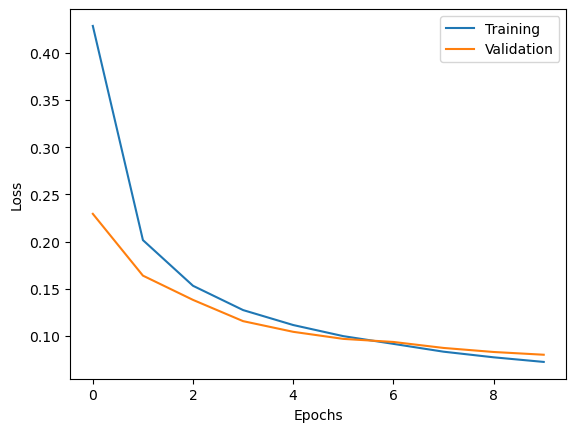

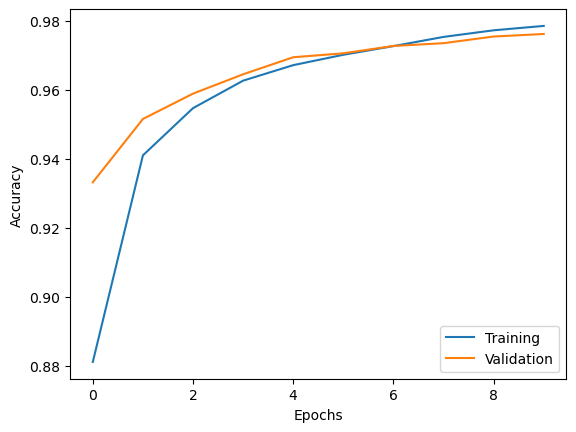

In [29]:
plot_history(cnn_do_hist)

In [30]:
cnn_do_model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9726 - loss: 0.0932 


[0.07817832380533218, 0.9761000275611877]

Now the accuracies for training, validation and test data are more in line.

In [31]:
cnn_do_model.save('mnist_cnn_do.h5')